# Masked Autoregressive Flows (MAFs)

In [66]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable, Any

import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing Masked Linear layer

In [2]:
from normflow.model import MaskedLinear

model = MaskedLinear(3)
input = jnp.arange(5)
mask = jnp.zeros((5, 3))
model.initialize_mask(mask)

params = model.init(jax.random.PRNGKey(0), input)

In [3]:
model.apply(params, input) #The mask is initialized at 0

Array([0., 0., 0.], dtype=float64)

In [4]:
mask = jnp.ones((5, 3))
model.initialize_mask(mask)
print(mask)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [5]:
model.apply(params, input) #The mask is full of one. You can check that you get the same result than with a dense layer.

Array([ 1.64494925,  0.90466881, -4.55038065], dtype=float64)

In [6]:
from normflow.model import ConditionalMADE

In [7]:
model = ConditionalMADE(3, [5, 5], n_cond=3, gaussian=True, random_order=True, seed=36, activation='silu')

In [8]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [9]:
input = jnp.array([0.5, 0.5, 0.5])
cond = jnp.array([1, 1, 1])
result = model.apply(params, input, cond) 

In [10]:
result

Array([ 0.16367364,  0.        , -0.02277961,  0.26304798,  0.        ,
       -0.04986673], dtype=float64)

### Testing MAF Layer

In [12]:
from normflow.model import MAFLayer

In [13]:
maf_layer = MAFLayer(3, 3, [5, 5], reverse=False, seed=100, activation='silu')

In [14]:
params = maf_layer.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [15]:
input = jnp.arange(3)
cond = jnp.zeros(3)

maf_layer.apply(params, input, cond)

Array([ 0.        ,  0.        , -0.00258241,  0.        ,  0.        ,
        0.01258937], dtype=float64)

In [16]:
u, log_det = maf_layer.apply(params, input, cond, method="forward")
u, log_det

(Array([0.        , 1.        , 2.01522779], dtype=float64),
 Array(0.00629468, dtype=float64))

In [17]:
maf_layer.apply(params, u.reshape(1, 3), cond.reshape(1, 3), method="backward") #We check that the MAFLayer is indeedinvertible.

(Array([[0., 1., 2.]], dtype=float64), Array([-0.00629468], dtype=float64))

### Testing MAF

In [35]:
from normflow.model import ConditionalMAF

In [44]:
maf = ConditionalMAF(3, 3, 2, [128, 128], use_reverse=False, seed=42, activation='silu')

In [45]:
input = jnp.arange(9).reshape((3,3))
cond = jnp.zeros((3,3))
train = True
variables  = maf.init(jax.random.PRNGKey(0), input, cond, train=True)

In [46]:
u, log_det = maf.apply(variables, input, cond)
u, log_det

(Array([[ 0.        ,  1.        ,  2.10509021],
        [ 3.        ,  5.62404077,  7.47547051],
        [ 6.        , 18.8012329 , 18.50269527]], dtype=float64),
 Array([0.02389768, 0.70138165, 1.64236452], dtype=float64))

In [47]:
maf.apply(variables, u, cond, method='backward') #Same here, the transformation is invertible.

(Array([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], dtype=float64),
 Array([-0.02389768, -0.70138165, -1.64236452], dtype=float64))

## Simulation model

In [48]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'lotka_volterra',
 'two_moons',
 'sir',
 'slcp',
 'gaussian_linear',
 'bernoulli_glm',
 'gaussian_linear_uniform',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [49]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]

print(dim, dim_cond)

5 8


In [50]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, index):
        return self.thetas[index], self.xs[index]

In [51]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

## Neural posterior estimation using MAFs

In [64]:
from normflow.model import ConditionalMAF

In [74]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
        
    def print_tabulate(self, exmp_input):
        pass


In [54]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_data=dim,
    n_cond=dim_cond,
    n_layers=5,
    hidden_dims=[128, 128],
    activation='silu',
    optimizer_hparams={'lr': 4e-3},
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    debug=False,
    use_reverse=True
)

In [56]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [57]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 3.8921065349405906
Validation loss: 4.935445719769822
Test loss: 4.846827189999734


In [58]:
model = trainer.bind_model()

In [59]:
key = jax.random.PRNGKey(0)

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

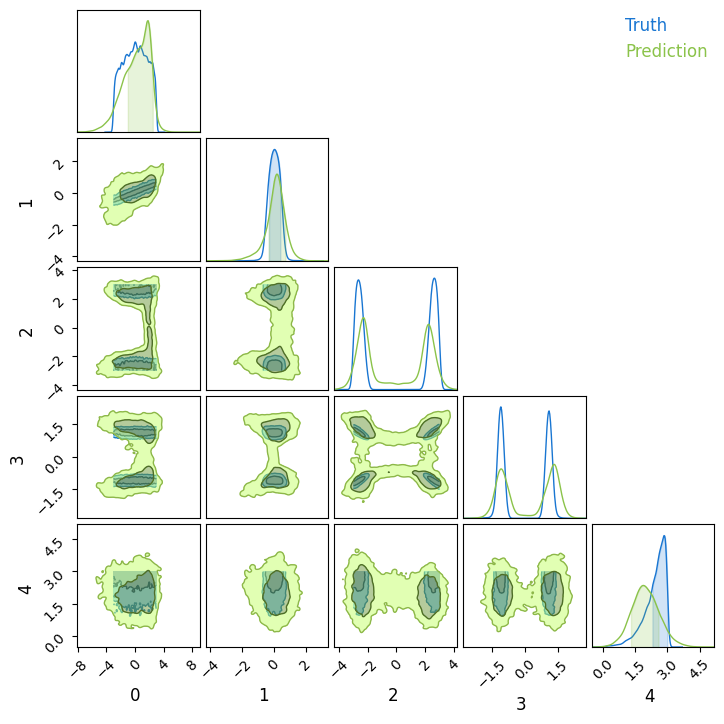

In [61]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [62]:
samples_image, _ = model.apply({'params': trainer.state.params}, reference_samples, observation*jnp.ones((10000, 1)), train=False)

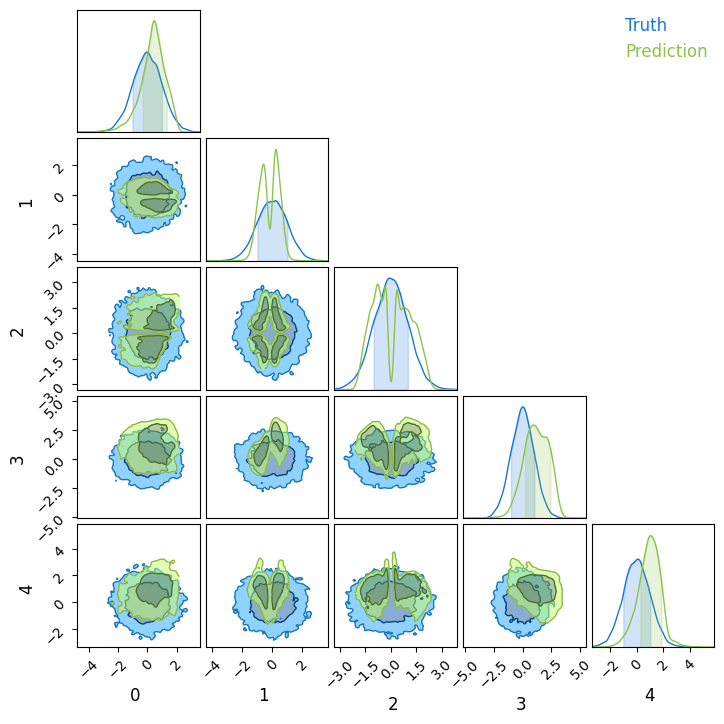

In [63]:
c = ChainConsumer()
c.add_chain(jax.random.multivariate_normal(key, jnp.zeros(5), jnp.eye(5), (10000,)), shade_alpha = 0.5, name='Truth')
c.add_chain(samples_image, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [50]:
%load_ext tensorboard
%tensorboard --logdir ~/work/jax/notebooks/checkpoints/

## Optimizing hyperparameter choice with Optuna

In [70]:
import optuna

In [71]:
CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints'

In [75]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = MAFTrainer(n_in=dim, #Create your trainer
                         n_cond=dim_cond,
                            n_layers=trial.suggest_int('n_components', 3, 8),
                            layers=[128, 128],
                            use_reverse=trial.suggest_categorical('use_reverse', [True, False]),
                            activation='silu',
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader)), #beware of the training input.
                            check_val_every_epoch=5,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [77]:
study = optuna.create_study(
    study_name='maf_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/maf_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-02-16 09:57:09,141] A new study created in RDB with name: maf_slcp_hparam_search
[W 2024-02-16 10:02:04,028] Trial 0 failed with parameters: {'n_components': 7, 'use_reverse': False, 'lr': 0.002971835919752354} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/local/home/sg276684/anaconda3/envs/jax_sbi/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_113234/1458759946.py", line 19, in objective
    metrics = trainer.train_model(my_train_loader,
  File "/local/home/sg276684/Documents/SBI/sbi_jax/normflow/train.py", line 302, in train_model
    train_metrics = self.train_epoch(train_loader)
  File "/local/home/sg276684/Documents/SBI/sbi_jax/normflow/train.py", line 346, in train_epoch
    for batch in self.tracker(train_loader, desc='Training', leave=False):
  File "/local/home/sg276684/anaconda3/envs/jax_sbi/lib/python3.10/site-packages/torch/ut

KeyboardInterrupt: 